# Model Interpretation Methods

Welcome to the final assignment of course 3! In this assignment we will focus on the interpretation of machine learning and deep learning models. Using the techniques we've learned this week we'll revisit some of the models we've built throughout the course and try to understand a little more about what they're doing.

In this assignment you'll use various methods to interpret different types of machine learning models. In particular, you'll learn about the following topics:

- Interpreting Deep Learning Models
    - Understanding output using GradCAMs
- Feature Importance in Machine Learning
    - Permutation Method
    - SHAP Values

Let's get started.

### This assignment covers the folowing topics:

- [1. Interpreting Deep Learning Models](#1)
  - [1.1 GradCAM](#1-1)
    - [1.1.1 Getting Intermediate Layers](#1-1-1)
    - [1.1.2 Getting Gradients](#1-1-2)
    - [1.1.3 Implementing GradCAM](#1-1-3)
      - [Exercise 1](#ex-01)
    - [1.1.4 Using GradCAM to Visualize Multiple Labels](#1-1-4)
      - [Exercise 2](#ex-02)
- [2. Feature Importance in Machine Learning](#2)
  - [2.1 Permuation Method for Feature Importance](#2-1)
    - [2.1.1 Implementing Permutation](#2-1-1)
      - [Exercise 3](#ex-03)
    - [2.1.2 Implementing Importance](#2-1-2)
      - [Exercise 4](#ex-04)
    - [2.1.3 Computing our Feature Importance](#2-1-3)
  - [2.2 Shapley Values for Random Forests](#2-2)
    - [2.2.1 Visualizing Feature Importance on Specific Individuals](#2-2-1)
    - [2.2.2 Visualizing Feature Importance on Aggregate](#2-2-2)
    - [2.2.3 Visualizing Interactions between Features](#2-2-3)

## Packages

We'll first import the necessary packages for this assignment.

- `keras`: we'll use this framework to interact with our deep learning model
- `matplotlib`: standard plotting library
- `pandas`: we'll use this to manipulate data
- `numpy`: standard python library for numerical operations
- `cv2`: library that contains convenience functions for image processing
- `sklearn`: standard machine learning library
- `lifelines`: we'll use their implementation of the c-index
- `shap`: library for interpreting and visualizing machine learning models using shapley values


In [2]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sklearn
import lifelines
import shap


from util import *

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

<a name="1"></a>
## 1 Interpreting Deep Learning Models

To start, let's try understanding our X-ray diagnostic model from Course 1 Week 1. Run the next cell to load in the model (it should take a few seconds to complete).

In [3]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


Let's load in an X-ray image to develop on. Run the next cell to load and show the image.

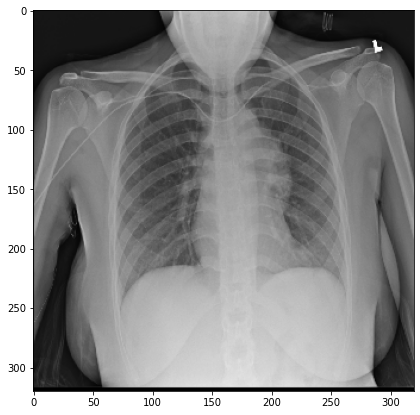

In [4]:
IMAGE_DIR = 'nih_new/images-small/'
df = pd.read_csv("nih_new/train-small.csv")
im_path = IMAGE_DIR + '00025288_001.png' 
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

Next, let's get our predictions. Before we plug the image into our model, we have to normalize it. Run the next cell to compute the mean and standard deviation of the images in our training set. 

In [5]:
mean, std = get_mean_std_per_batch(df)

Now we are ready to normalize and run the image through our model to get predictions.

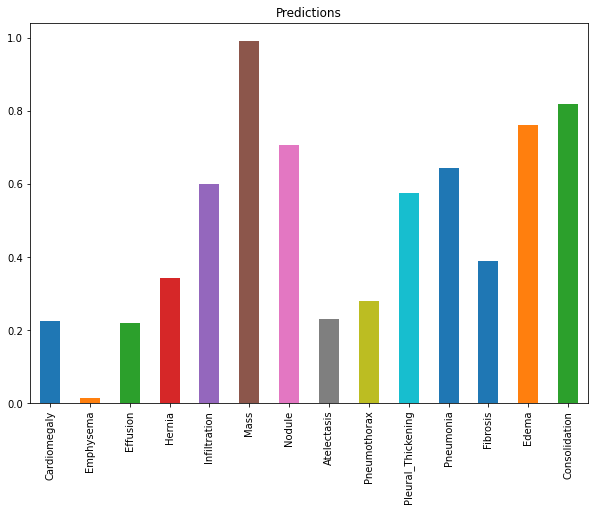

In [6]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.show()

We see, for example, that the model predicts Mass (abnormal spot or area in the lungs that are more than 3 centimeters) with high probability. Indeed, this patient was diagnosed with mass. However, we don't know where the model is looking when it's making its own diagnosis. To gain more insight into what the model is looking at, we can use GradCAMs.

<a name="1-1"></a>
### 1.1 GradCAM

GradCAM is a technique to visualize the impact of each region of an image on a specific output for a Convolutional Neural Network model. Through GradCAM, we can generate a heatmap by computing gradients of the specific class scores we are interested in visualizing.

<a name="1-1-1"></a>
#### 1.1.1 Getting Intermediate Layers

Perhaps the most complicated part of computing GradCAM is accessing intermediate activations in our deep learning model and computing gradients with respect to the class output. Now we'll go over one pattern to accomplish this, which you can use when implementing GradCAM.

In order to understand how to access intermediate layers in a computation, first let's see the layers that our model is composed of. This can be done by calling Keras convenience function `model.summary()`. Do this in the cell below.

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

There are a lot of layers, but typically we'll only be extracting one of the last few. Remember that the last few layers usually have more abstract information. To access a layer, we can use `model.get_layer(layer).output`, which takes in the name of the layer in question. Let's try getting the `conv5_block16_concat` layer, the raw output of the last convolutional layer.

In [8]:
spatial_maps =  model.get_layer('conv5_block16_concat').output
print(spatial_maps)

Tensor("conv5_block16_concat/concat:0", shape=(?, ?, ?, 1024), dtype=float32)


Now, this tensor is just a placeholder, it doesn't contain the actual activations for a particular image. To get this we will use [Keras.backend.function](https://www.tensorflow.org/api_docs/python/tf/keras/backend/function) to return intermediate computations while the model is processing a particular input. This method takes in an input and output placeholders and returns a function. This function will compute the intermediate output (until it reaches the given placeholder) evaluated given the input. For example, if you want the layer that you just retrieved (conv5_block16_concat), you could write the following:

In [9]:
get_spatial_maps = K.function([model.input], [spatial_maps])
print(get_spatial_maps)

We see that we now have a `Function` object. Now, to get the actual intermediate output evaluated with a particular input, we just plug in an image to this function:

In [10]:
# get an image
x = load_image_normalize(im_path, mean, std)
print(f"x is of type {type(x)}")
print(f"x is of shape {x.shape}")

x is of type <class 'numpy.ndarray'>
x is of shape (1, 320, 320, 3)


In [11]:
# get the spatial maps layer activations (a list of numpy arrays)
spatial_maps_x_l = get_spatial_maps([x])

print(f"spatial_maps_x_l is of type {type(spatial_maps_x_l)}")
print(f"spatial_maps_x_l is has length {len(spatial_maps_x_l)}")

spatial_maps_x_l is of type <class 'list'>
spatial_maps_x_l is has length 1


In [12]:
# get the 0th item in the list
spatial_maps_x = spatial_maps_x_l[0]
print(f"spatial_maps_x is of type {type(spatial_maps_x)}")
print(f"spatial_maps_x is of shape {spatial_maps_x.shape}")

spatial_maps_x is of type <class 'numpy.ndarray'>
spatial_maps_x is of shape (1, 10, 10, 1024)


Notice that the shape is (1, 10, 10, 1024).  The 0th dimension of size 1 is the batch dimension.  Remove the batch dimension for later calculations by taking the 0th index of spatial_maps_x.

In [13]:
# Get rid of the batch dimension
spatial_maps_x = spatial_maps_x[0] # equivalent to spatial_maps_x[0,:]
print(f"spatial_maps_x without the batch dimension has shape {spatial_maps_x.shape}")
print("Output some of the content:")
print(spatial_maps_x[0])

spatial_maps_x without the batch dimension has shape (10, 10, 1024)
Output some of the content:
[[-0.49458444  0.18865144 -0.59939295 ...  0.11193523 -0.05752101
   0.14348939]
 [-0.8482704  -0.2923373  -0.8553379  ...  0.20083968 -0.09198014
   0.24828047]
 [-0.5281645  -0.1300962  -0.52980214 ...  0.26649946 -0.11014077
   0.3004736 ]
 ...
 [-0.4013137  -0.34288323 -0.9362184  ...  0.16762535 -0.07800627
   0.23842122]
 [-0.5103229  -0.33157453 -0.5768972  ...  0.20275849 -0.10227268
   0.29715663]
 [-0.3342641   0.4823789  -0.21996601 ...  0.07917964 -0.04257992
   0.16637692]]


We now have the activations for that particular image, and we can use it for interpretation. The function that is returned by calling `K.function([model.input], [spatial_maps])` (saved here in the variable `get_spatial_maps`) is sometimes referred to as a "hook", letting you peek into the intermediate computations in the model. 

<a name="1-1-2"></a>
#### 1.1.2 Getting Gradients

The other major step in computing GradCAMs is getting gradients with respect to the output for a particular class. Luckily, Keras makes getting gradients simple. We can use the [Keras.backend.gradients](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients) function. The first parameter is the value you are taking the gradient of, and the second is the parameter you are taking that gradient with respect to. We illustrate below: 

In [14]:
# get the output of the model
output_with_batch_dim = model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")

Model output includes batch dimension, has shape (?, 14)


To get the output without the batch dimension, you can take the 0th index of the tensor. Note that because the batch dimension is 'None', you could actually enter any integer index, but let's just use 0.

In [15]:
# Get the output without the batch dimension
output_all_categories = output_with_batch_dim[0]
print(f"The output for all 14 categories of disease has shape {output_all_categories.shape}")

The output for all 14 categories of disease has shape (14,)


The output has 14 categories, one for each disease category, indexed from 0 to 13. Cardiomegaly is the disease category at index 0.

In [16]:
# Get the first category's output (Cardiomegaly) at index 0
y_category_0 = output_all_categories[0]
print(f"The Cardiomegaly output is at index 0, and has shape {y_category_0.shape}")

The Cardiomegaly output is at index 0, and has shape ()


In [17]:
# Get gradient of y_category_0 with respect to spatial_maps

gradient_l = K.gradients(y_category_0, spatial_maps)
print(f"gradient_l is of type {type(gradient_l)} and has length {len(gradient_l)}")

# gradient_l is a list of size 1.  Get the gradient at index 0
gradient = gradient_l[0]
print(gradient)

gradient_l is of type <class 'list'> and has length 1
Tensor("gradients/AddN:0", shape=(?, ?, ?, 1024), dtype=float32)


Again, this is just a placeholder. Just like for intermediate layers, we can use `K.function` to compute the value of the gradient for a particular input.  

The K.function() takes in
- a list of inputs: in this case, one input, 'model.input'
- a list of tensors: in this case, one output tensor 'gradient'

It returns a function that calculates the activations of the list of tensors.
- This returned function returns a list of the activations, one for each tensor that was passed into K.function().

In [18]:
# Create the function that gets the gradient
get_gradient = K.function([model.input], [gradient])
type(get_gradient)

keras.backend.tensorflow_backend.Function

In [19]:
# get an input x-ray image
x = load_image_normalize(im_path, mean, std)
print(f"X-ray image has shape {x.shape}")

X-ray image has shape (1, 320, 320, 3)


The `get_gradient` function takes in a list of inputs, and returns a list of the gradients, one for each image.

In [20]:
# use the get_gradient function to get the gradient (pass in the input image inside a list)
grad_x_l = get_gradient([x])
print(f"grad_x_l is of type {type(grad_x_l)} and length {len(grad_x_l)}")

# get the gradient at index 0 of the list.
grad_x_with_batch_dim = grad_x_l[0]
print(f"grad_x_with_batch_dim is type {type(grad_x_with_batch_dim)} and shape {grad_x_with_batch_dim.shape}")

# To remove the batch dimension, take the value at index 0 of the batch dimension
grad_x = grad_x_with_batch_dim[0]
print(f"grad_x is type {type(grad_x)} and shape {grad_x.shape}")

print("Gradient grad_x (show some of its content:")
print(grad_x[0])

grad_x_l is of type <class 'list'> and length 1
grad_x_with_batch_dim is type <class 'numpy.ndarray'> and shape (1, 10, 10, 1024)
grad_x is type <class 'numpy.ndarray'> and shape (10, 10, 1024)
Gradient grad_x (show some of its content:
[[-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 ...
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]]


Just like we had a hook into the penultimate layer, we now have a hook into the gradient! This allows us to easily compute pretty much anything relevant to our model output. 

We can also combine the two to have one function call which gives us both the gradient and the last layer (this might come in handy when implementing GradCAM in the next section).

In [21]:
# Use K.function to generate a single function
# Notice that a list of two tensors, is passed in as the second argument of K.function()
get_spatial_maps_and_gradient = K.function([model.input], [spatial_maps, gradient])
print(type(get_spatial_maps_and_gradient))

<class 'keras.backend.tensorflow_backend.Function'>


In [22]:
# The returned function returns a list of the evaluated tensors
tensor_eval_l = get_spatial_maps_and_gradient([x])
print(f"tensor_eval_l is type {type(tensor_eval_l)} and length {len(tensor_eval_l)}")

tensor_eval_l is type <class 'list'> and length 2


In [23]:
# store the two numpy arrays from index 0 and 1 into their own variables
spatial_maps_x_with_batch_dim, grad_x_with_batch_dim = tensor_eval_l
print(f"spatial_maps_x_with_batch_dim has shape {spatial_maps_x_with_batch_dim.shape}")
print(f"grad_x_with_batch_dim has shape {grad_x_with_batch_dim.shape}")

spatial_maps_x_with_batch_dim has shape (1, 10, 10, 1024)
grad_x_with_batch_dim has shape (1, 10, 10, 1024)


In [24]:
# Note: you could also do this directly from the function call:
spatial_maps_x_with_batch_dim, grad_x_with_batch_dim = get_spatial_maps_and_gradient([x])
print(f"spatial_maps_x_with_batch_dim has shape {spatial_maps_x_with_batch_dim.shape}")
print(f"grad_x_with_batch_dim has shape {grad_x_with_batch_dim.shape}")

spatial_maps_x_with_batch_dim has shape (1, 10, 10, 1024)
grad_x_with_batch_dim has shape (1, 10, 10, 1024)


In [25]:
# Remove the batch dimension by taking the 0th index at the batch dimension
spatial_maps_x = spatial_maps_x_with_batch_dim[0]
grad_x = grad_x_with_batch_dim[0]
print(f"spatial_maps_x shape {spatial_maps_x.shape}")
print(f"grad_x shape {grad_x.shape}")

print("\nSpatial maps (print some content):")
print(spatial_maps_x[0])
print("\nGradient (print some content:")
print(grad_x[0])

spatial_maps_x shape (10, 10, 1024)
grad_x shape (10, 10, 1024)

Spatial maps (print some content):
[[-0.49458444  0.18865144 -0.59939295 ...  0.11193523 -0.05752101
   0.14348939]
 [-0.8482704  -0.2923373  -0.8553379  ...  0.20083968 -0.09198014
   0.24828047]
 [-0.5281645  -0.1300962  -0.52980214 ...  0.26649946 -0.11014077
   0.3004736 ]
 ...
 [-0.4013137  -0.34288323 -0.9362184  ...  0.16762535 -0.07800627
   0.23842122]
 [-0.5103229  -0.33157453 -0.5768972  ...  0.20275849 -0.10227268
   0.29715663]
 [-0.3342641   0.4823789  -0.21996601 ...  0.07917964 -0.04257992
   0.16637692]]

Gradient (print some content:
[[-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211011e-05  5.8568861e-05]
 ...
 [-1.2738859e-09  2.5665678e-09  3.0076833e-07 ...  8.3982741e-05
  -5.6211

<a name="1-1-3"></a>
#### 1.1.3 Implementing GradCAM

<a name='ex-01'></a>
### Exercise 1

In the next cell, fill in the `grad_cam` method to produce GradCAM visualizations for an input model and image. This is fairly complicated, so it might help to break it down into these steps:

1. Hook into model output and last layer activations.
2. Get gradients of last layer activations with respect to output.
3. Compute value of last layer and gradients for input image.
4. Compute weights from gradients by global average pooling.
5. Compute the dot product between the last layer and weights to get the score for each pixel.
6. Resize, take ReLU, and return cam. 

<details>
    <summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    
 The following hints follow the order of the sections described above.
 1. Remember that the output shape of our model will be [1, class_amount]. 
     1. The input in this case will always have batch_size = 1
 2. See [K.gradients](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)
 3. Follow the procedure we used in the previous two sections.
 4. Check the axis; make sure weights have shape (C)!
 5. See [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)
     </details>

To test, you will compare your output on an image to the output from a correct implementation of GradCAM. You will receive full credit if the pixel-wise mean squared error is less than 0.05.

In [39]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def grad_cam(input_model, image, category_index, layer_name):
    """
    GradCAM method for visualizing input saliency.
    
    Args:
        input_model (Keras.model): model to compute cam for
        image (tensor): input to model, shape (1, H, W, 3)
        cls (int): class to compute cam with respect to
        layer_name (str): relevant layer in model
        H (int): input height
        W (int): input width
    Return:
        cam ()
    """
    cam = None
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # 1. Get placeholders for class output and last layer
    # Get the model's output
    output_with_batch_dim = input_model.output
    
    # Remove the batch dimension
    output_all_categories = output_with_batch_dim[0]
    
    # Retrieve only the disease category at the given category index
    y_c = output_all_categories[category_index]
    
    # Get the input model's layer specified by layer_name, and retrive the layer's output tensor
    spatial_map_layer = input_model.get_layer(layer_name).output

    # 2. Get gradients of last layer with respect to output

    # get the gradients of y_c with respect to the spatial map layer (it's a list of length 1)
    grads_l = K.gradients(y_c,spatial_map_layer)
    
    # Get the gradient at index 0 of the list
    grads = grads_l[0]
       
    # 3. Get hook for the selected layer and its gradient, based on given model's input
    # Hint: Use the variables produced by the previous two lines of code
    spatial_map_and_gradient_function =  K.function([input_model.input], [spatial_map_layer, grads])
    
    # Put in the image to calculate the values of the spatial_maps (selected layer) and values of the gradients
    spatial_map_all_dims, grads_val_all_dims = spatial_map_and_gradient_function([image])

    # Reshape activations and gradient to remove the batch dimension
    # Shape goes from (B, H, W, C) to (H, W, C)
    # B: Batch. H: Height. W: Width. C: Channel    
    # Reshape spatial map output to remove the batch dimension
    spatial_map_val = spatial_map_all_dims[0]
    
    # Reshape gradients to remove the batch dimension
    grads_val = grads_val_all_dims[0]
    
    # 4. Compute weights using global average pooling on gradient 
    # grads_val has shape (Height, Width, Channels) (H,W,C)
    # Take the mean across the height and also width, for each channel
    # Make sure weights have shape (C)
    weights =  np.mean(grads_val,axis=(0,1))
    
    # 5. Compute dot product of spatial map values with the weights
    cam = np.dot(spatial_map_val,weights)

    ### END CODE HERE ###
    
    # We'll take care of the postprocessing.
    H, W = image.shape[1], image.shape[2]
    cam = np.maximum(cam, 0) # ReLU so we only get positive importance
    cam = cv2.resize(cam, (W, H), cv2.INTER_NEAREST)
    cam = cam / cam.max()

    return cam

Below we generate the CAM for the image and compute the error (pixel-wise mean squared difference) from the expected values according to our reference. 

In [40]:
im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 5, 'conv5_block16_concat') # Mass is class 5

# Loads reference CAM to compare our implementation with.
reference = np.load("reference_cam.npy")
error = np.mean((cam-reference)**2)

print(f"Error from reference: {error:.4f}, should be less than 0.05")

Error from reference: 0.0305, should be less than 0.05


Run the next cell to visualize the CAM and the original image. 

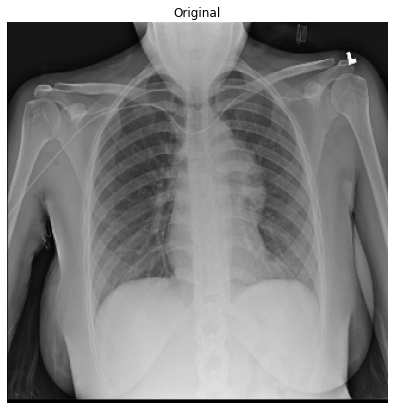

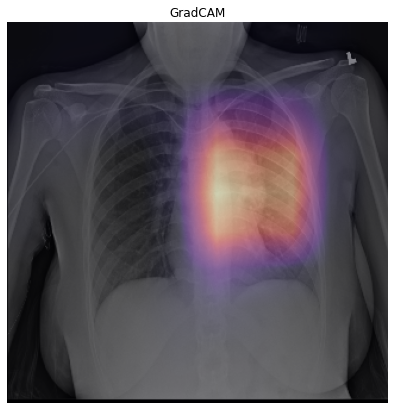

In [41]:
plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, cmap='magma', alpha=0.5)
plt.title("GradCAM")
plt.axis('off')
plt.show()

We can see that it focuses on the large (white) empty area on the right lung. Indeed this is a clear case of Mass.

<a name="1-1-4"></a>
#### 1.1.4 Using GradCAM to Visualize Multiple Labels

<a name='ex-02'></a>
### Exercise 2

We can use GradCAMs for multiple labels on the same image. Let's do it for the labels with best AUC for our model, Cardiomegaly, Mass, and Edema. 

In [50]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_gradcam(model, img, mean, std, data_dir, df, 
                    labels, selected_labels, layer_name='conv5_block16_concat'):
    """
    Compute GradCAM for many specified labels for an image. 
    This method will use the `grad_cam` function.
    
    Args:
        model (Keras.model): Model to compute GradCAM for
        img (string): Image name we want to compute GradCAM for.
        mean (float): Mean to normalize to image.
        std (float): Standard deviation to normalize the image.
        data_dir (str): Path of the directory to load the images from.
        df(pd.Dataframe): Dataframe with the image features.
        labels ([str]): All output labels for the model.
        selected_labels ([str]): All output labels we want to compute the GradCAM for.
        layer_name: Intermediate layer from the model we want to compute the GradCAM for.
    """
    img_path = data_dir + img
    preprocessed_input = load_image_normalize(img_path, mean, std)
    predictions = model.predict(preprocessed_input)
    print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(df[df["Image"] == img][labels].values[0]))[0]))

    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
    
    j = 1
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###    
    # Loop through all labels
    for i in range(len(labels)): # complete this line
        # Compute CAM and show plots for each selected label.
        
        # Check if the label is one of the selected labels
        if labels[i] in selected_labels: # complete this line
            
            # Use the grad_cam function to calculate gradcam
            gradcam = grad_cam(model,preprocessed_input,i,layer_name)
            
            ### END CODE HERE ###
            
            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=min(0.5, predictions[0][i]))
            j +=1

Run the following cells to print the ground truth diagnosis for a given case and show the original x-ray as well as GradCAMs for Cardiomegaly, Mass, and Edema.

Ground Truth:  Cardiomegaly
Generating gradcam for class Cardiomegaly (p=0.98)
Generating gradcam for class Mass (p=0.29)
Generating gradcam for class Edema (p=0.11)


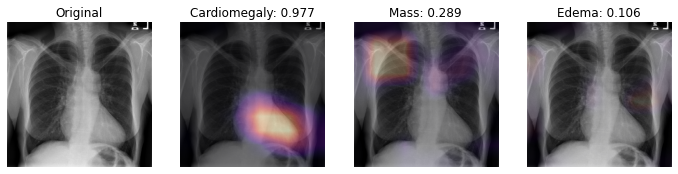

In [51]:
df = pd.read_csv("nih_new/train-small.csv")

image_filename = '00016650_000.png'
labels_to_show = ['Cardiomegaly', 'Mass', 'Edema']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, df, labels, labels_to_show)

The model correctly predicts absence of mass or edema. The probability for mass is higher, and we can see that it may be influenced by the shapes in the middle of the chest cavity, as well as around the shoulder. We'll run it for two more images. 

Ground Truth:  Mass
Generating gradcam for class Cardiomegaly (p=0.02)
Generating gradcam for class Mass (p=0.99)
Generating gradcam for class Edema (p=0.34)


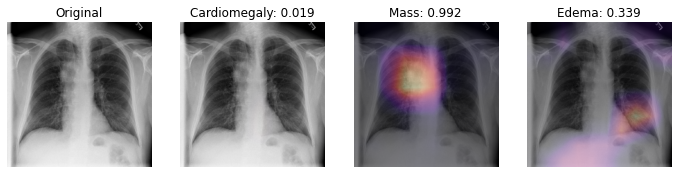

In [52]:
image_filename = '00005410_000.png'
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, df, labels, labels_to_show)

In the example above, the model correctly focuses on the mass near the center of the chest cavity. 

Ground Truth:  Edema
Generating gradcam for class Cardiomegaly (p=0.74)
Generating gradcam for class Mass (p=0.25)
Generating gradcam for class Edema (p=0.99)


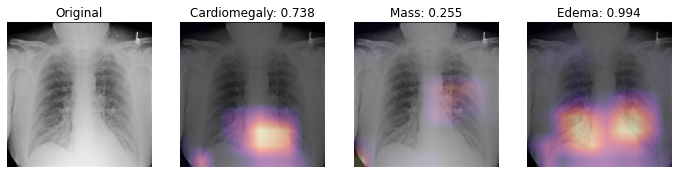

In [53]:
image_name = '00004090_002.png'
compute_gradcam(model, image_name, mean, std, IMAGE_DIR, df, labels, labels_to_show)

Here the model correctly picks up the signs of edema near the bottom of the chest cavity. We can also notice that Cardiomegaly has a high score for this image, though the ground truth doesn't include it. This visualization might be helpful for error analysis; for example, we can notice that the model is indeed looking at the expected area to make the prediction.

This concludes the section on GradCAMs. We hope you've gained an appreciation for the importance of interpretation when it comes to deep learning models in medicine. Interpretation tools like this one can be helpful for discovery of markers, error analysis, and even in deployment. 

<a name="2"></a>
## 2 Feature Importance in Machine Learning

When developing predictive models and risk measures, it's often helpful to know which features are making the most difference. This is easy to determine in simpler models such as linear models and decision trees. However as we move to more complex models to achieve high performance, we usually sacrifice some interpretability. In this assignment we'll try to regain some of that interpretability using Shapley values, a technique which has gained popularity in recent years, but which is based on classic results in cooperative game theory. 

We'll revisit our random forest model from course 2 module 2 and try to analyze it more closely using Shapley values. Run the next cell to load in the data and model from that assignment and recalculate the test set c-index.

In [54]:
rf = pickle.load(open('nhanes_rf.sav', 'rb')) # Loading the model
test_df = pd.read_csv('nhanest_test.csv')
test_df = test_df.drop(test_df.columns[0], axis=1)
X_test = test_df.drop('y', axis=1)
y_test = test_df.loc[:, 'y']
cindex_test = cindex(y_test, rf.predict_proba(X_test)[:, 1])

print("Model C-index on test: {}".format(cindex_test))

Model C-index on test: 0.7776169781865744


Run the next cell to print out the riskiest individuals according to our model. 

In [55]:
X_test_risky = X_test.copy(deep=True)
X_test_risky.loc[:, 'risk'] = rf.predict_proba(X_test)[:, 1] # Predicting our risk.
X_test_risky = X_test_risky.sort_values(by='risk', ascending=False) # Sorting by risk value.
X_test_risky.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
572,70.0,80.0,312.0,1.0,54.8,7.0,4.4,222.0,52.0,1.57,7.2,1.0,180.0,417.0,12.5,7.5,45.770473,100.0,0.77
190,69.0,100.0,316.0,1.0,77.7,26.0,4.2,197.0,65.0,1.49,7.5,1.0,165.0,298.0,21.8,8.8,22.129018,65.0,0.69
1300,73.0,80.0,999.0,1.0,52.6,35.0,3.9,258.0,61.0,1.66,6.8,1.0,150.0,314.0,19.4,9.4,26.466850,70.0,0.69
634,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.68
1221,74.0,80.0,67.0,1.0,40.3,24.0,3.7,139.0,28.0,1.91,6.4,2.0,140.0,495.0,5.7,4.1,22.066389,60.0,0.68


<a name="2-1"></a>
### 2.1 Permuation Method for Feature Importance

First we'll try to determine feature importance using the permutation method. In the permutation method, the importance of feature $i$ would be the regular performance of the model minus the performance with the values for feature $i$ permuted in the dataset. This way we can assess how well a model without that feature would do without having to train a new model for each feature. 

<a name="2-1-1"></a>
#### 2.1.1 Implementing Permutation

<a name='ex-03'></a>
### Exercise 3

Complete the implementation of the function below, which given a feature name returns a dataset with those feature values randomly permuted. 

<details>
    <summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul>
        <li>
            See <a href=https://numpy.org/devdocs/reference/random/generated/numpy.random.permutation.html> np.random.permutation</a>
        </li>
    </ul>
</details>

In [56]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def permute_feature(df, feature):
    """
    Given dataset, returns version with the values of
    the given feature randomly permuted. 

    Args:
        df (dataframe): The dataset, shape (num subjects, num features)
        feature (string): Name of feature to permute
    Returns:
        permuted_df (dataframe): Exactly the same as df except the values
                                of the given feature are randomly permuted.
    """
    permuted_df = df.copy(deep=True) # Make copy so we don't change original df

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # Permute the values of the column 'feature'
    permuted_features = np.random.permutation(permuted_df[feature])
    
    # Set the column 'feature' to its permuted values.
    permuted_df[feature] = permuted_features
    
    ### END CODE HERE ###

    return permuted_df

In [57]:
print("Test Case")

example_df = pd.DataFrame({'col1': [0, 1, 2], 'col2':['A', 'B', 'C']})
print("Original dataframe:")
print(example_df)
print("\n")

print("col1 permuted:")
print(permute_feature(example_df, 'col1'))

print("\n")
print("Compute average values over 1000 runs to get expected values:")
col1_values = np.zeros((3, 1000))
np.random.seed(0) # Adding a constant seed so we can always expect the same values and evaluate correctly. 
for i in range(1000):
    col1_values[:, i] = permute_feature(example_df, 'col1')['col1'].values

print("Average of col1: {}, expected value: [0.976, 1.03, 0.994]".format(np.mean(col1_values, axis=1)))

Test Case
Original dataframe:
   col1 col2
0     0    A
1     1    B
2     2    C


col1 permuted:
   col1 col2
0     1    A
1     2    B
2     0    C


Compute average values over 1000 runs to get expected values:
Average of col1: [0.976 1.03  0.994], expected value: [0.976, 1.03, 0.994]


<a name="2-1-2"></a>
#### 2.1.2 Implementing Importance

<a name='ex-04'></a>
### Exercise 4

Now we will use the function we just created to compute feature importances (according to the permutation method) in the function below.

<details>
    <summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
\begin{align}
I_x  = \left\lvert perf - perf_x  \right\rvert
\end{align}

where $I_x$ is the importance of feature $x$ and
\begin{align}
perf_x  = \frac{1}{n}\cdot \sum_{i=1}^{n} perf_i^{sx}
\end{align}

where $perf_i^{sx}$ is the performance with the feature $x$ shuffled in the $i$th permutation.
</details>

In [58]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def permutation_importance(X, y, model, metric, num_samples = 100):
    """
    Compute permutation importance for each feature.

    Args:
        X (dataframe): Dataframe for test data, shape (num subject, num features)
        y (np.array): Labels for each row of X, shape (num subjects,)
        model (object): Model to compute importances for, guaranteed to have
                        a 'predict_proba' method to compute probabilistic 
                        predictions given input
        metric (function): Metric to be used for feature importance. Takes in ground
                           truth and predictions as the only two arguments
        num_samples (int): Number of samples to average over when computing change in
                           performance for each feature
    Returns:
        importances (dataframe): Dataframe containing feature importance for each
                                 column of df with shape (1, num_features)
    """

    importances = pd.DataFrame(index = ['importance'], columns = X.columns)
    
    # Get baseline performance (note, you'll use this metric function again later)
    baseline_performance = metric(y, model.predict_proba(X)[:, 1])

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # Iterate over features (the columns in the importances dataframe)
    for feature in importances.columns: # complete this line
        
        # Compute 'num_sample' performances by permutating that feature
        
        # You'll see how the model performs when the feature is permuted
        # You'll do this num_samples number of times, and save the performance each time
        # To store the feature performance,
        # create a numpy array of size num_samples, initialized to all zeros
        feature_performance_arr = np.zeros(num_samples)
        
        # Loop through each sample
        for i in range(len(feature_performance_arr)): # complete this line
            
            # permute the column of dataframe X
            perm_X = permute_feature(X,feature)
           
            # calculate the performance with the permuted data
            # Use the same metric function that was used earlier
            feature_performance_arr[i] = metric(y,model.predict_proba(perm_X)[:,1])
    
    
        # Compute importance: absolute difference between 
        # the baseline performance and the average across the 
        importances[feature]['importance'] = abs(baseline_performance - np.mean(feature_performance_arr))
        
    ### END CODE HERE ###

    return importances

**Test Case**

In [59]:
print("Test Case")
print("\n")
print("We check our answers on a Logistic Regression on a dataset")
print("where y is given by a sigmoid applied to the important feature.") 
print("The unimportant feature is random noise.")
print("\n")
example_df = pd.DataFrame({'important': np.random.normal(size=(1000)), 'unimportant':np.random.normal(size=(1000))})
example_y = np.round(1 / (1 + np.exp(-example_df.important)))
example_model = sklearn.linear_model.LogisticRegression(fit_intercept=False).fit(example_df, example_y)

example_importances = permutation_importance(example_df, example_y, example_model, cindex, num_samples=100)
print("Computed importances:")
print(example_importances)
print("\n")
print("Expected importances (approximate values):")
print(pd.DataFrame({"important": 0.50, "unimportant": 0.00}, index=['importance']))
print("If you round the actual values, they will be similar to the expected values")

Test Case


We check our answers on a Logistic Regression on a dataset
where y is given by a sigmoid applied to the important feature.
The unimportant feature is random noise.


Computed importances:
           important  unimportant
importance  0.496674  2.89012e-05


Expected importances (approximate values):
            important  unimportant
importance        0.5          0.0
If you round the actual values, they will be similar to the expected values


<a name="2-1-3"></a>
#### 2.1.3 Computing our Feature Importance

Next, we compute importances on our dataset. Since we are computing the permutation importance for all the features, it might take a few minutes to run.

In [60]:
importances = permutation_importance(X_test, y_test, rf, cindex, num_samples=100)
importances

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
importance,0.147772,0.0113034,0.0111148,0.000449158,0.000805694,0.006285,0.00527172,0.000848118,0.000203789,0.00274019,0.00154867,0.0272337,0.00618949,0.00225922,0.000425288,0.00256128,0.00304884,0.00379624


Let's plot these in a bar chart for easier comparison.

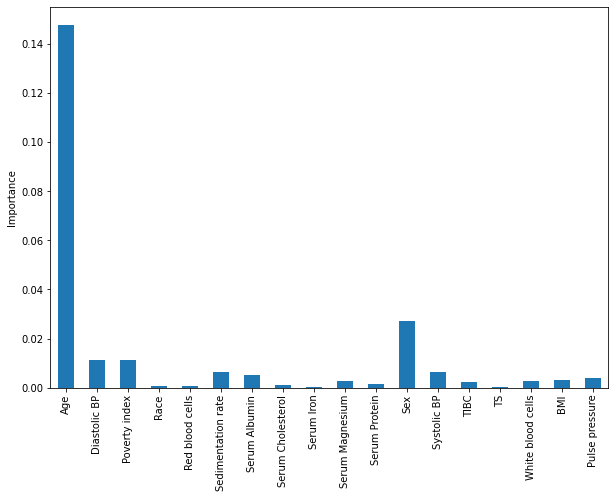

In [61]:
importances.T.plot.bar()
plt.ylabel("Importance")
l = plt.legend()
l.remove()
plt.show()

You should see age as by far the best prediction of near term mortality, as one might expect. Next is sex, followed by diastolic blood pressure. Interestingly, the poverty index also has a large impact, despite the fact that it is not directly related to an individual's health. This alludes to the importance of social determinants of health in our model. 

<a name="2-2"></a>
### 2.2 Shapley Values for Random Forests

We'll contrast the permutation method with a more recent technique known as Shapley values (actually, Shapley values date back to the mid 20th century, but have only been applied to machine learning very recently). 

<a name="2-2-1"></a>
#### 2.2.1 Visualizing Feature Importance on Specific Individuals

We can use Shapley values to try and understand the model output on specific individuals. In general Shapley values take exponential time to compute, but luckily there are faster approximations for forests in particular that run in polynomial time. Run the next cell to display a 'force plot' showing how each feature influences the output for the first person in our dataset. If you want more information about 'force plots' and other decision plots, please take a look at [this notebook](https://github.com/slundberg/shap/blob/master/notebooks/plots/decision_plot.ipynb) by the `shap` library creators.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


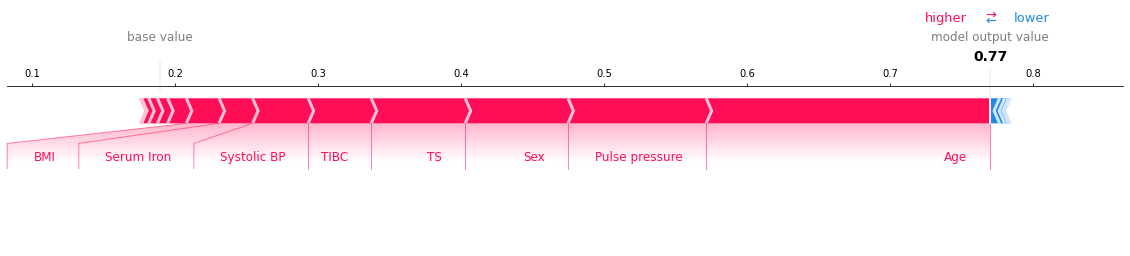

In [62]:
explainer = shap.TreeExplainer(rf)
i = 0 # Picking an individual
shap_value = explainer.shap_values(X_test.loc[X_test_risky.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

For this individual, their age, pulse pressure, and sex were the biggest contributors to their high risk prediction. Note how shapley values give us greater granularity in our interpretations. 

Feel free to change the `i` value above to explore the feature influences for different individuals.

<a name="2-2-2"></a>
#### 2.2.2 Visualizing Feature Importance on Aggregate

Just like with the permutation method, we might also want to understand model output in aggregate. Shapley values allow us to do this as well. Run the next cell to initialize the shapley values for each example in the test set (this may also take a few minutes). 

In [63]:
shap_values = shap.TreeExplainer(rf).shap_values(X_test)[1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


You can ignore the `setting feature_perturbation` message.

Run the next cell to see a summary plot of the shapley values for each feature on each of the test examples. The colors indicate the value of the feature. The features are listed in terms of decreasing absolute average shapley value over all the individuals in the dataset.

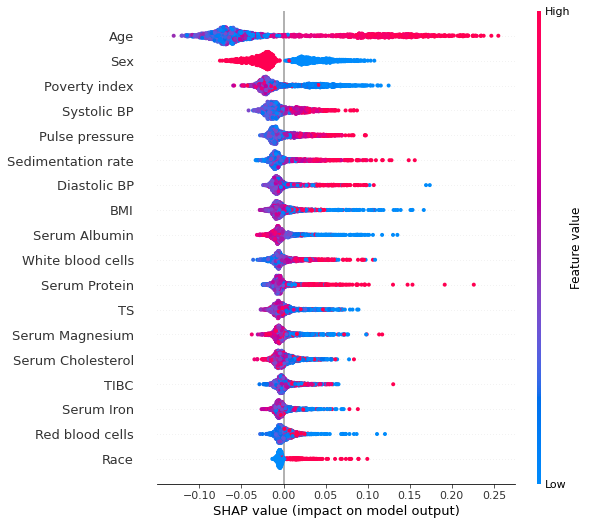

In [64]:
shap.summary_plot(shap_values, X_test)

In the above plot, you might be able to notice a high concentration of points on specific SHAP value ranges. This means that a high proportion of our test set lies on those ranges.

As with the permutation method, age, sex, poverty index, and diastolic BP seem to be the most important features. Being older has a negative impact on mortality, and being a woman (sex=2.0) has a positive effect. 

<a name="2-2-3"></a>
#### 2.2.3 Visualizing Interactions between Features

The `shap` library also lets you visualize interactions between features using dependence plots. These plot the Shapley value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in shapley value for a single value of the main feature.

Run the next cell to see the interaction between Age and Sex. 

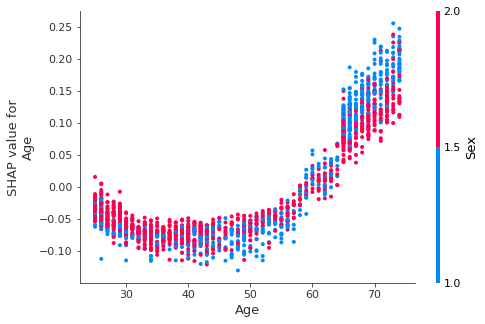

In [65]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index = 'Sex')

We see that while Age > 50 is generally bad (positive Shapley value), being a woman (red points) generally reduces the impact of age. This makes sense since we know that women generally live longer than men. 

Run the next cell to see the interaction between Poverty index and Age 

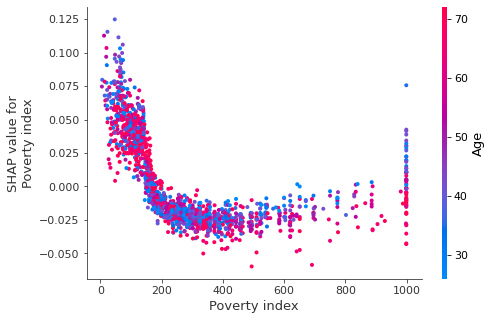

In [66]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')

We see that the impact of poverty index drops off quickly, and for higher income individuals age begins to explain much of variation in the impact of poverty index. We encourage you to try some other pairs and see what other interesting relationships you can find!

Congratulations! You've completed the final assignment of course 3, well done! 